# Recipe Project

**Name(s)**: Ryan Lindberg

**Website Link**: lindbergryan04.github.io/reponame

In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import plotly.express as px
import ast
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.plotting.backend = 'plotly'
from dsc80_utils import * 

## Step 1: Introduction

In [4]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', '{:.2f}'.format)

In [64]:
food_data = pd.read_csv('data/RAW_recipes.csv')
interactions_data = pd.read_csv('data/RAW_interactions.csv')
interactions_data['recipe_id'] = interactions_data['recipe_id'].astype(int)
recipes = food_data.merge(interactions_data, how = 'left', right_on = 'recipe_id', left_on = 'id')
recipes = recipes.set_index('id').drop(columns = ['Unnamed: 0_x','Unnamed: 0_y','recipe_id'])

In [72]:
recipes

name  minutes  contributor_id  \
id                                                                              
333281          1 brownies in the world    best ever       40          985201   
453467            1 in canada chocolate chip cookies       45         1848091   
306168                        412 broccoli casserole       40           50969   
306168                        412 broccoli casserole       40           50969   
306168                        412 broccoli casserole       40           50969   
...                                              ...      ...             ...   
308080                     zydeco ya ya deviled eggs       40           37779   
298512        cookies by design   cookies on a stick       29          506822   
298509  cookies by design   sugar shortbread cookies       20          506822   
298509  cookies by design   sugar shortbread cookies       20          506822   
298509  cookies by design   sugar shortbread cookies       20          506822   

         submitted  ...       user_id        date  rating  \
id                  ...                                     
333281  2008-10-27  ...     386585.00  2008-11-19    4.00   
453467  2011-04-11  ...     424680.00  2012-01-26    5.00   
306168  2008-05-30  ...      29782.00  2008-12-31    5.00   
306168  2008-05-30  ...    1196280.00  2009-04-13    5.00   
306168  2008-05-30  ...     768828.00  2013-08-02    5.00   
...            ...  ...           ...         ...     ...   
308080  2008-06-07  ...     844554.00  2009-10-14    5.00   
298512  2008-04-15  ...     804234.00  2008-05-02    1.00   
298509  2008-04-15  ...     866651.00  2008-06-19    1.00   
298509  2008-04-15  ...    1546277.00  2010-02-08    5.00   
298509  2008-04-15  ... 1803287907.00  2014-11-01    0.00   

                                                   review  
id                                                         
333281  These were pretty good, but took forever to ba...  
453467  Originally I was gonna cut the recipe in half ...  
306168  This was one of the best broccoli casseroles t...  
306168  I made this for my son's first birthday party ...  
306168  Loved this.  Be sure to completely thaw the br...  
...                                                   ...  
308080  These were very good. I meant to add some jala...  
298512  I would rate this a zero if I could. I followe...  
298509  This recipe tastes nothing like the Cookies by...  
298509  yummy cookies, i love this recipe me and my sm...  
298509  I work at a Cookies By Design and can say this...  

[234429 rows x 15 columns]

## Understanding the Data

| Column            | Description                                                         | Unique Values or Range |
|------------------|---------------------------------------------------------------------|------------------------|
| `'id'`           | Recipe ID                                                          | Unique ID values       |
| `'name'`         | Recipe name                                                        | Various text values    |
| `'minutes'`      | Minutes required to prepare the recipe                            | Varies (integer)       |
| `'contributor_id'` | User ID who submitted the recipe                                 | Unique ID values       |
| `'submitted'`    | Date the recipe was submitted                                     | YYYY-MM-DD format      |
| `'tags'`         | Food.com tags associated with the recipe                          | List of text values    |
| `'nutrition'`    | Nutrition information `[calories (#), total fat (PDV), sugar (PDV), sodium (PDV), protein (PDV), saturated fat (PDV), carbohydrates (PDV)]` | List of numerical values |
| `'n_steps'`      | Number of steps in the recipe                                    | Integer                |
| `'steps'`        | Text for the recipe steps, in order                              | List of text values    |
| `'description'`  | User-provided description of the recipe                          | Text                   |
| `'user_id'`      | ID of the user who interacted with the recipe                    | Unique ID values       |
| `'date'`         | Date of the interaction                                          | YYYY-MM-DD format      |
| `'rating'`       | Rating given in the interaction                                  | Integer (1-5)          |
| `'review'`       | Review text from the interaction                                | Text                   |



**Note:** Not all recipes have ratings due to the left merge, so some rows may have missing values for user_id, date, rating, and review.

### Possible Questions:

**1.** What types of recipes tend to be healthier (i.e. more protein, fewer carbs)?

**2.** What types of recipes tend to have higher average ratings?

**3.** What is the relationship between the number of steps and rating of recipes?

**4.** What is the relationship between nutritional metrics (e.g., calories, total fat, sugar) and user ratings?

**5.** Which recipes offer the best balance between healthiness, quick preparation, and taste?

**Motivation:**

Since Ethan and I have transferred to UCSD, our cooking has devolved to become a bit less healthy due to lack of food access and lack of time. We're curious about what ingredients/recipes we could  use to help us fix this issue. Ideally these recipes are cost effective in terms of time and money, and use simple ingredients. Also, the food should be tasty of course!

We think **Question #5** will be the best to help us solve our predicament. 

## Step 2: Data Cleaning and Exploratory Data Analysis

### Cleaning

Replace 0 ratings with np.nan:

In [73]:
recipes['rating'] = recipes['rating'].replace(0, np.nan)

Add avg_rating column (avg rating for each recipe):

In [74]:
recipes['avg_rating'] = recipes.groupby('id')['rating'].transform('mean')

Remove unnecessary columns:

In [75]:
recipes = recipes.drop(columns = ['review','contributor_id','user_id','date','submitted','description','steps'])

Convert string lists to actual lists:

For example: The string "['60-minutes-or-less', 'time-to-make', 'course']" from tags column, or the string '[138.4, 10.0, 50.0, 3.0, 3.0, 19.0, 6.0]' from nutrition column.

In [76]:
columns_to_convert = ['tags','nutrition','ingredients']  

for col in columns_to_convert:
    recipes[col] = recipes[col].apply(ast.literal_eval)

Parse nutrition lists into their own columns:

  `[calories (#), total fat (PDV), sugar (PDV), sodium (PDV), protein (PDV), saturated fat (PDV), carbohydrates (PDV)]`

In [77]:
recipes[[
    'calories',
    'total_fat',
    'sugar',
    'sodium',
    'protein',
    'sat_fat',
    'carbs'
]] = pd.DataFrame(recipes['nutrition'].tolist(), index=recipes.index)

In [78]:
recipes.columns

Index(['name', 'minutes', 'tags', 'nutrition', 'n_steps', 'ingredients',
       'n_ingredients', 'rating', 'avg_rating', 'calories', 'total_fat',
       'sugar', 'sodium', 'protein', 'sat_fat', 'carbs'],
      dtype='object')

In [79]:
recipes = recipes.drop(columns = ['nutrition'])

In [80]:
recipes

name  minutes  \
id                                                              
333281          1 brownies in the world    best ever       40   
453467            1 in canada chocolate chip cookies       45   
306168                        412 broccoli casserole       40   
306168                        412 broccoli casserole       40   
306168                        412 broccoli casserole       40   
...                                              ...      ...   
308080                     zydeco ya ya deviled eggs       40   
298512        cookies by design   cookies on a stick       29   
298509  cookies by design   sugar shortbread cookies       20   
298509  cookies by design   sugar shortbread cookies       20   
298509  cookies by design   sugar shortbread cookies       20   

                                                     tags  n_steps  ...  \
id                                                                  ...   
333281  [60-minutes-or-less, time-to-make, course, mai...       10  ...   
453467  [60-minutes-or-less, time-to-make, cuisine, pr...       12  ...   
306168  [60-minutes-or-less, time-to-make, course, mai...        6  ...   
306168  [60-minutes-or-less, time-to-make, course, mai...        6  ...   
306168  [60-minutes-or-less, time-to-make, course, mai...        6  ...   
...                                                   ...      ...  ...   
308080  [60-minutes-or-less, time-to-make, course, mai...        7  ...   
298512  [30-minutes-or-less, time-to-make, course, pre...        9  ...   
298509  [30-minutes-or-less, time-to-make, course, pre...        5  ...   
298509  [30-minutes-or-less, time-to-make, course, pre...        5  ...   
298509  [30-minutes-or-less, time-to-make, course, pre...        5  ...   

       sodium  protein  sat_fat  carbs  
id                                      
333281   3.00     3.00    19.00   6.00  
453467  22.00    13.00    51.00  26.00  
306168  32.00    22.00    36.00   3.00  
306168  32.00    22.00    36.00   3.00  
306168  32.00    22.00    36.00   3.00  
...       ...      ...      ...    ...  
308080   3.00     6.00     5.00   0.00  
298512  11.00     7.00    21.00   9.00  
298509   4.00     4.00    11.00   6.00  
298509   4.00     4.00    11.00   6.00  
298509   4.00     4.00    11.00   6.00  

[234429 rows x 15 columns]

### Exploratory Analysis

In [118]:
eda_recipes = recipes.copy()

Lets look at the descriptive statistics of rating and prep time:

In [119]:
print(eda_recipes['minutes'].describe())
print(eda_recipes['avg_rating'].describe())

count    234429.00
mean        106.79
std        3285.97
min           0.00
25%          20.00
50%          35.00
75%          60.00
max     1051200.00
Name: minutes, dtype: float64
count   231652.00
mean         4.68
std          0.50
min          1.00
25%          4.50
50%          4.86
75%          5.00
max          5.00
Name: avg_rating, dtype: float64


The mean rating for all recipes is 4.65, which is oddly high. On a 1-10 scale thats equivalent to 9.3. Either the recipes in this dataset are very good, or the ratings are biased towards higher values. 

In [120]:
eda_recipes_sample = eda_recipes[eda_recipes['minutes'] < 200].sample(n=5000, random_state=0)

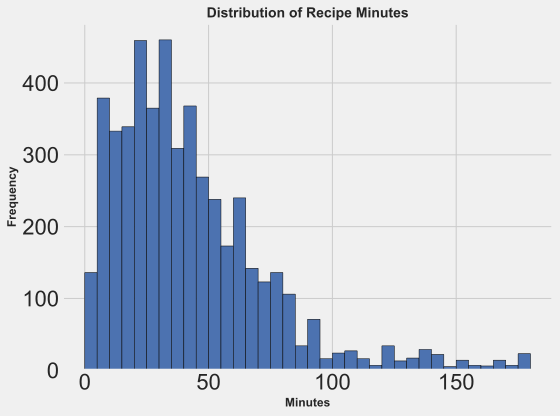

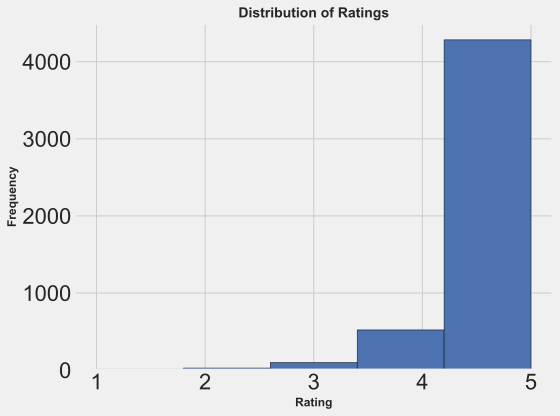

In [121]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(8, 6))
plt.hist(eda_recipes_sample['minutes'], bins=np.arange(0, 185, 5),
         edgecolor='black', color='#4c72b0')  # A pleasing blue

plt.ticklabel_format(style='plain', axis='x')
plt.xlabel("Minutes", fontsize=12, fontweight='bold')
plt.ylabel("Frequency", fontsize=12, fontweight='bold')
plt.title("Distribution of Recipe Minutes", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


plt.style.use('fivethirtyeight')

plt.figure(figsize=(8, 6))
plt.hist(eda_recipes_sample['avg_rating'], bins=5,
         edgecolor='black', color='#4c72b0')  # A pleasing blue

plt.ticklabel_format(style='plain', axis='x')
plt.xlabel("Rating", fontsize=12, fontweight='bold')
plt.ylabel("Frequency", fontsize=12, fontweight='bold')
plt.title("Distribution of Ratings", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Next, which numerical variables are most linearly correlated with rating?

In [122]:
eda_recipes_sample2 = eda_recipes.sample(n=5000, random_state=0)

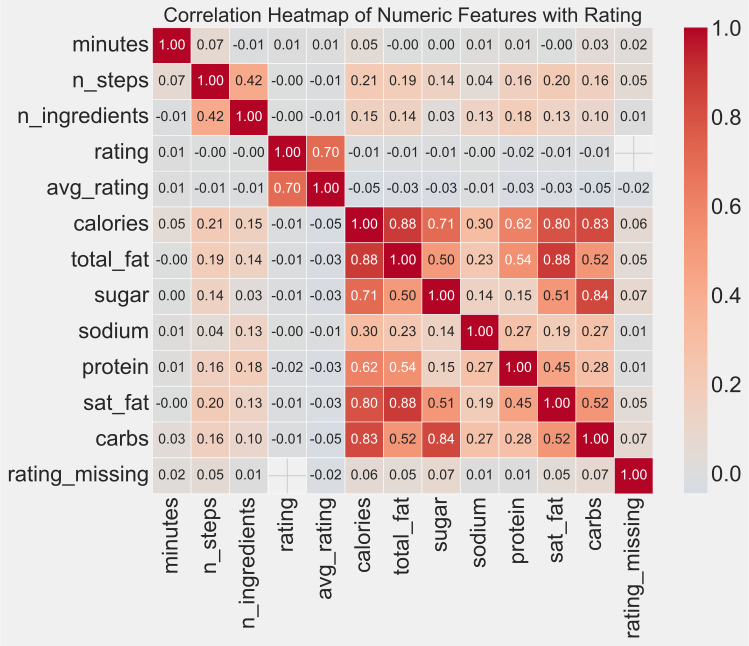

In [126]:

# Step 1: Create a binary column for rating missingness
eda_recipes_sample2['rating_missing'] = eda_recipes_sample2['rating'].isna().astype(int)

# Step 2: Select only numeric columns (for correlation analysis)
numeric_cols = eda_recipes_sample2.select_dtypes(include=[np.number])

# Step 3: Compute the correlation matrix
corr_matrix = numeric_cols.corr()

# Step 4: Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=0.5)

# Step 5: Title and show
plt.title("Correlation Heatmap of Numeric Features with Rating")
plt.show()

It seems that no linear correlation between any numerical variable and avg_rating. My intuition would lead me to think maybe sugar and minutes or calories would have some association. Maybe there are hidden, perhaps non-linear relationships that we are not seeing.

Avg_rating is looking like it will be hard to predict. We will likely have to do further exploration and feature engineering to solve this.

Lets take a look at the pivot table of number of steps and avg rating to see if we an recognize any patterns.

In [108]:
# Ensure 'n_steps' and 'rating' are numeric
eda_recipes_sample2['n_steps'] = pd.to_numeric(eda_recipes_sample2['n_steps'], errors='coerce')
eda_recipes_sample2['rating'] = pd.to_numeric(eda_recipes_sample2['avg_rating'], errors='coerce')

# Create a pivot table that aggregates average rating and recipe count by number of steps
pivot_complexity = eda_recipes_sample2.pivot_table(index='n_steps', values='avg_rating', aggfunc=['mean', 'count'])
pivot_complexity.iloc[0:20]

mean      count
        avg_rating avg_rating
n_steps                      
1             4.60         77
2             4.66        155
3             4.65        268
4             4.62        289
5             4.61        390
6             4.57        368
7             4.59        416
8             4.61        380
9             4.56        367
10            4.59        362
11            4.57        290
12            4.65        267
13            4.62        224
14            4.62        178
15            4.53        149
16            4.69        113
17            4.63         89
18            4.50         86
19            4.77         69
20            4.69         54

Lets take a look at the scatter plots to investigate further.

In [109]:
cols_to_scatter = [
    'calories',
    'total_fat',
    'sugar',
    'sodium',
    'protein',
    'sat_fat',
    'carbs',
    'n_steps',
    'minutes'
]

# 2) Melt the DataFrame from wide to long format
melted = eda_recipes_sample2.melt(
    id_vars='avg_rating',         # keep 'rating' as is
    value_vars=cols_to_scatter, 
    var_name='nutrient',      # new column with nutrient name
    value_name='value'        # new column with the nutrient’s value
)

# 3) Use a relplot with facets
g = sns.relplot(
    data=melted,
    x='avg_rating', 
    y='value', 
    col='nutrient',       # create a separate subplot (facet) for each nutrient
    col_wrap=3,           # wrap into rows of 3 subplots
    kind='scatter',
    height=4, aspect=1.2, # tweak subplot size
    alpha=0.5             # transparency helps if points overlap
)
g.set_titles("{col_name}")  # Simplify subplot titles
plt.show()


## Step 3: Assessment of Missingness

In [111]:
# Check for missing values in each column
missing_values = recipes.isnull().sum()
print("Missing values per column:")
print(missing_values)

Missing values per column:
name                  1
minutes               0
tags                  0
n_steps               0
ingredients           0
n_ingredients         0
rating            15036
avg_rating         2777
calories              0
total_fat             0
sugar                 0
sodium                0
protein               0
sat_fat               0
carbs                 0
rating_missing        0
dtype: int64


The rating column has 15036 missing values. This is due to the fact that some users did not leave a 1-5 rating with their review, causing it to default to 0. These 0 values were replaced with np.nan during the cleaning process. In many cases, this is likely NMAR, because the value of the missing rating is dependent on the missing rating itself. This missingness is common with reviews and ratings, and is known as 'review bias,' which is the phenomenon that describes how people tend to only leave ratings when they have a strong opinion on something. These users who left no rating likely had a neutral opinion on the recipe, and therefore didn't feel compelled to give it a rating.

Avg_rating has missing some values as well, likely for the same reasons some ratings are missing. 

Lets do some permutation tests to explore further. First we will assess if missing rating is dependent on the 'n_steps' column. Lets assume a p-value cutoff of 0.05.

Observed Difference in Mean Step Count: 1.3386
P-value: 0.0000


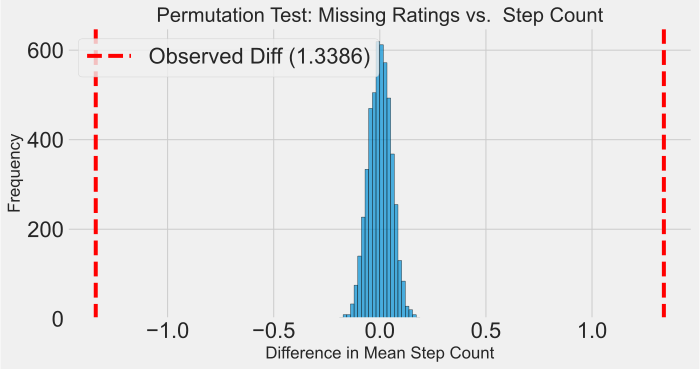

In [91]:
plt.style.use('fivethirtyeight')

# Step 1: Create a binary column for missingness
eda_recipes['rating_missing'] = eda_recipes['rating'].isna()

# Step 2: Compute observed difference in mean prep_time
obs_diff = eda_recipes.groupby('rating_missing')['n_steps'].mean().diff().iloc[-1]

# Step 3: Define permutation test function
def permutation_test(data, group_col, value_col, n_permutations=5000):
    observed_diff = data.groupby(group_col)[value_col].mean().diff().iloc[-1]
    perm_diffs = []

    for _ in range(n_permutations):
        shuffled_labels = np.random.permutation(data[group_col])
        permuted_diff = data.assign(shuffled_label=shuffled_labels).groupby('shuffled_label')[value_col].mean().diff().iloc[-1]
        perm_diffs.append(permuted_diff)

    p_value = np.mean(np.abs(perm_diffs) >= np.abs(observed_diff))
    return observed_diff, perm_diffs, p_value

# Step 4: Run permutation test
obs_diff, perm_diffs, p_value = permutation_test(eda_recipes, 'rating_missing', 'n_steps')

# Step 5: Print results
print(f"Observed Difference in Mean Step Count: {obs_diff:.4f}")
print(f"P-value: {p_value:.4f}")

# Step 6: Plot the permutation distribution
plt.hist(perm_diffs, bins=30, alpha=0.7, edgecolor='black')
plt.axvline(obs_diff, color='red', linestyle='dashed', label=f'Observed Diff ({obs_diff:.4f})')
plt.axvline(-obs_diff, color='red', linestyle='dashed')
plt.xlabel('Difference in Mean Step Count')
plt.ylabel('Frequency')
plt.title('Permutation Test: Missing Ratings vs. Step Count')
plt.legend()
plt.show()


Lets look at the kde plots:

In [127]:
# Step 1: Remove rows where 'n_steps' is NaN or infinite
eda_recipes_clean = eda_recipes.dropna(subset=['n_steps'])
eda_recipes_clean = eda_recipes_clean[np.isfinite(eda_recipes_clean['n_steps'])]

# Step 2: Ensure 'rating_missing' is correctly assigned
eda_recipes_clean['rating_missing'] = eda_recipes_clean['rating'].isna().map({
    True: 'Missing',
    False: 'Not Missing'
})

# Step 3: Store original KDE plot
fig_original = create_kde_plotly(
    df=eda_recipes_clean,
    group_col='rating_missing',
    group1='Missing',
    group2='Not Missing',
    vals_col='n_steps',
    title="Original Density of n_steps by Missingness of Rating"
)

fig_original.show()

# Step 4: Perform one permutation by shuffling 'rating_missing' labels
shuffled_labels = np.random.permutation(eda_recipes_clean['rating_missing'])
eda_recipes_permuted = eda_recipes_clean.copy()
eda_recipes_permuted['rating_missing'] = shuffled_labels  # Assign shuffled labels

# Step 5: Create KDE plot for permuted data
fig_permuted = create_kde_plotly(
    df=eda_recipes_permuted,
    group_col='rating_missing',
    group1='Missing',
    group2='Not Missing',
    vals_col='n_steps',
    title="Permuted Density of n_steps by Missingness of Rating"
)

fig_permuted.show()



It appears that the missingness of rating may be dependent on the number of steps in a recipe! This could be due to many reasons. If we consider the fact that these are users who *did* leave a review, but *didn't* leave a rating, the true reason for this relationship is harder to track down. Users may feel that they didn't do the long and complex recipe justice, and therefore be reluctant to leave a rating because they don't trust their judgement. Or perhaps they had a higher expectation of the complex recipe, and were reluctant to show that it didn't turn out as well as they had hoped.

Lets take a look at the relationship between missing rating vs minutes to see if we find the same relationship.

Observed Difference in Mean minutes: 51.4524
P-value: 0.1160


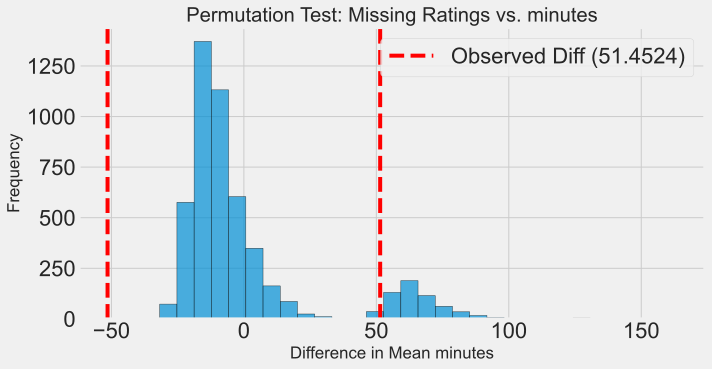

In [124]:
# Compute observed difference in minutes
obs_diff = recipes.groupby('rating_missing')['minutes'].mean().diff().iloc[-1]

# Run permutation test
obs_diff, perm_diffs, p_value = permutation_test(eda_recipes, 'rating_missing', 'minutes')

# Print results
print(f"Observed Difference in Mean minutes: {obs_diff:.4f}")
print(f"P-value: {p_value:.4f}")

# Plot the permutation distribution
plt.hist(perm_diffs, bins=30, alpha=0.7, edgecolor='black')
plt.axvline(obs_diff, color='red', linestyle='dashed', label=f'Observed Diff ({obs_diff:.4f})')
plt.axvline(-obs_diff, color='red', linestyle='dashed')
plt.xlabel('Difference in Mean minutes')
plt.ylabel('Frequency')
plt.title('Permutation Test: Missing Ratings vs. minutes')
plt.legend()
plt.show()

In [125]:
eda_recipes_clean = eda_recipes[eda_recipes['minutes'] < 100]

# Step 2: Ensure 'rating_missing' is correctly assigned
eda_recipes_clean['rating_missing'] = eda_recipes_clean['rating'].isna().map({
    True: 'Missing',
    False: 'Not Missing'
})

# Step 3: Store original KDE plot
fig_original = create_kde_plotly(
    df=eda_recipes_clean,
    group_col='rating_missing',
    group1='Missing',
    group2='Not Missing',
    vals_col='minutes',
    title="Original Density of minutes by Missingness of Rating"
)

fig_original.show()

# Step 4: Perform one permutation by shuffling 'rating_missing' labels
shuffled_labels = np.random.permutation(eda_recipes_clean['rating_missing'])
eda_recipes_permuted = eda_recipes_clean.copy()
eda_recipes_permuted['rating_missing'] = shuffled_labels  # Assign shuffled labels

# Step 5: Create KDE plot for permuted data
fig_permuted = create_kde_plotly(
    df=eda_recipes_permuted,
    group_col='rating_missing',
    group1='Missing',
    group2='Not Missing',
    vals_col='minutes',
    title="Permuted Density of minutes by Missingness of Rating"
)

fig_permuted.show()

Although this relationship looks similar, it looks like its not statistically significant with a p-val of 0.11.

In conclusion, it appears that the missingness of rating is a combination of MAR (dependent on the 'n_steps' column) and NMAR, but unfortunately we can't prove this statement.

## Step 4: Hypothesis Testing

In [ ]:
# TODO

## Step 5: Framing a Prediction Problem

2. Data Preprocessing and Feature Engineering
Extract Nutritional Data:
Parse the nutrition column into individual features (calories, total fat, sugar, sodium, protein, saturated fat, carbohydrates). This will allow you to standardize each metric.

Normalization:
Normalize each feature so that all metrics are on a similar scale. For example, convert calories and protein into z-scores or min–max scaled values.

Create Derived Metrics:

Healthiness Score: A possible formulation might be:
Healthiness = (Normalized Protein) – (Normalized Calories + Normalized Saturated Fat + Normalized Sodium)
(You can adjust the formula and include other nutrients as needed.)
Quickness Score: Compute something like:
Quickness = 1 / (1 + minutes)
so that lower preparation times yield a higher score.
Taste Score: Directly use the normalized average rating.

3. Constructing the Composite Score
Combine the three components using a weighted sum:

Composite Score
=
�
×
Healthiness Score
+
�
×
Taste Score
+
�
×
Quickness Score
Composite Score=α×Healthiness Score+β×Taste Score+γ×Quickness Score
Weights (α, β, γ):
These values represent how important each component is relative to the others. You can start with equal weights or adjust them based on your personal preference (e.g., if healthiness is your top priority, choose a higher α).


4. Model Development Options
You have a couple of paths for implementing this:

Rule-Based Model:
Start with the weighted sum approach described above. This is transparent and easy to adjust, especially if you don’t have a target variable that directly represents the “ideal” balance.

Supervised Machine Learning:
If you have historical data where recipes are labeled (or you can derive a target composite score from user interactions), you could train a regression model (e.g., linear regression, random forest, gradient boosting) to predict the composite score from the features.

Training Data: Use your engineered features (healthiness, quickness, taste) and any additional recipe metadata.
Validation: Apply cross-validation to ensure that your model generalizes well.
Multi-Criteria Decision Making (MCDM):
Techniques like the Analytic Hierarchy Process (AHP) or TOPSIS can also be used to rank recipes based on multiple attributes. This might be particularly useful if you want a model that doesn't necessarily require a large training dataset.

5. Implementation and Evaluation
Model Tuning:
Experiment with different weight combinations (α, β, γ) to see how your recipe rankings change. You might use grid search or a similar optimization technique to find the best performing combination.

Validation:
Compare the composite scores against user feedback (ratings or reviews) to check if higher scores correlate with better perceived recipes.

Iterative Refinement:
Gather feedback and adjust the model. For instance, if you notice that recipes with short preparation times but very unhealthy profiles are scoring too high, you might need to penalize the healthiness score more heavily.

## Step 6: Baseline Model

In [ ]:
# TODO

## Step 7: Final Model

In [ ]:
# TODO

## Step 8: Fairness Analysis

In [ ]:
# TODO

In [ ]:
#eda_recipes = eda_recipes[~eda_recipes.index.duplicated(keep='first')]
#code to remove duplicate recipes (recipes with multiple ratings)
# might be useful later if we are working with avg_rating column, since the same recipe appears multiple times with the same avg_rating.